In [207]:
import torch
import torch.nn as nn
from torchvision import models , transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [208]:
torch.cuda.is_available()

True

In [209]:
device = torch.device("cuda")

In [210]:
def get_image(path,img_transform, size = (500,500)):
    image = Image.open(path)
    image = image.resize(size,Image.LANCZOS)
    #"Lanczos" refers to the Lanczos resampling algorithm, a mathematical technique 
    # used for image resizing, also known as Lanczos resampling.
    image = img_transform(image).unsqueeze(0)
    #this is required because we have to add batch size into image
    #it will add 1 for the array(tensor)
    return image.to(device)

def get_gram(m):
    _,c,h,w = m.size()

    m = m.view(c,h*w)
    m =torch.mm(m,m.t())
    return m

def denormalize_img(x):
    x = x.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225]) 
    #ImageNet images std and mean values
    #it will be useful because we will use transfer learning
    x = std*x+mean
    x = np.clip(x,0,1)
    return x



In [211]:
class FeatureExt(nn.Module):
    def __init__(self):
        super(FeatureExt, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features


In [212]:
model_Test = models.vgg16(pretrained=True)

In [213]:
model_Test

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [214]:
image_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean = (0.485,0.456,0.406),std = (0.229,0.224,0.225))])

Original_image = get_image("sky.jpg",image_transform)

Style_image = get_image("gogh.jpg",image_transform)

Resulted_image = Original_image.clone()
#the reason is that initial image created will be original image with 
#loss is 0 and add the style as we train(much faster than creating random parameter and then 
# match with the style)

In [215]:
Resulted_image.requires_grad
# wee need to make it learnable so 

False

In [216]:
Resulted_image.requires_grad = True

In [217]:
Resulted_image.requires_grad

True

In [218]:
optimizer = torch.optim.Adam([Resulted_image],lr = 0.05,betas=[0.5,0.8])
Epoch = 500
#learning rate and beta values are in the published article for Style Transfer
encoder = FeatureExt().to(device)

In [219]:
for p in encoder.parameters():
    p.requires_grad = False  #to freeze the layers for transfer learning

In [220]:
Content_weight = 1
Style_weight = 500  #These are the values published from the Style Network Transfer


for epoch in range(Epoch):

    Original_features = encoder(Original_image)
    Style_features = encoder(Style_image)
    Final_features = encoder(Resulted_image)

    Content_Loss = torch.mean((Original_features[-1]-Final_features[-1])**2)
    #last element of selected layer(relu activated layer)

    Style_Loss = 0

    for x_x,y_y in zip(Final_features,Style_features):
        _,c,h,w = x_x.size()
        gram_gen_feature = get_gram(x_x)
        gram_style_feature = get_gram(y_y)
        Style_Loss  = Style_Loss + torch.mean((gram_gen_feature-gram_style_feature)**2)/(c*h*w)
        # we are dividing to c*h*w to normalize the loss else it might be too big)
    loss = Content_weight*Content_Loss + Style_weight*Style_Loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%50 == 0:
        print(f"Epoch {epoch} :  Content loss: {Content_Loss.item():.4f} Style loss : {Style_Loss.item():.4f}")

Epoch 0 :  Content loss: 0.0000 Style loss : 10125.6191
Epoch 50 :  Content loss: 2.2873 Style loss : 80.4835
Epoch 100 :  Content loss: 2.5564 Style loss : 30.2769
Epoch 150 :  Content loss: 2.6679 Style loss : 16.1940
Epoch 200 :  Content loss: 2.7894 Style loss : 18.6539
Epoch 250 :  Content loss: 2.8226 Style loss : 10.4748
Epoch 300 :  Content loss: 2.8885 Style loss : 13.5659
Epoch 350 :  Content loss: 2.8653 Style loss : 9.1521
Epoch 400 :  Content loss: 2.7048 Style loss : 21.4585
Epoch 450 :  Content loss: 2.8858 Style loss : 13.0641


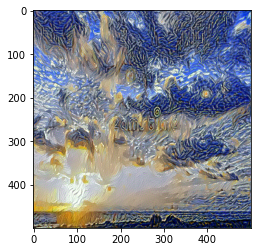

In [221]:
inp = Resulted_image.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)